# Nova Experiment Analysis Template

## Overview

This notebook provides automated analysis and visualization of nova simulation experiments. It analyzes the output from `scripts/analyze_vcf_results.py` to generate comprehensive performance metrics and publication-ready visualizations.

## Template Usage

1. **Configure Parameters**: Modify the experiment configuration in the cell below
2. **Run All Cells**: Execute the entire notebook for automated analysis
3. **Review Results**: Examine the generated plots and summary statistics

## Configuration

In [1]:
# EXPERIMENT CONFIGURATION - Modify these parameters for each experiment
EXPERIMENT_NAME = "one_read_per_window"
DATA_DIRECTORY = "../one_read_per_window"  # Path to experiment output directory
OUTPUT_PREFIX = "nova"  # Prefix used in analyze_vcf_results.py output files
ANALYSIS_TITLE = "Nova Variant Detection Performance Analysis"

# Optional: Override expected insertion counts if needed
# Leave as None to auto-detect from data
EXPECTED_INSERTIONS = None  # e.g., {'random': 400, 'simple': 200, 'AluYa5': 100}

# Display options
FIGURE_SIZE = (12, 8)
DPI = 100
SAVE_FIGURES = False  # Set to True to save plots as PNG files

## Setup and Imports

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = FIGURE_SIZE
plt.rcParams['figure.dpi'] = DPI
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

# Define consistent color scheme
COLORS = {
    'primary': '#2E8B57',     # Sea Green
    'secondary': '#4682B4',   # Steel Blue
    'accent': '#CD5C5C',      # Indian Red
    'success': '#2ECC71',     # Emerald
    'warning': '#F39C12',     # Orange
    'danger': '#E74C3C'       # Red
}

print(f"Analysis setup complete for: {EXPERIMENT_NAME}")
print(f"Timestamp: {pd.Timestamp.now()}")
print(f"Data directory: {DATA_DIRECTORY}")
print(f"Output prefix: {OUTPUT_PREFIX}")

Analysis setup complete for: one_read_per_window
Timestamp: 2025-06-30 14:25:57.302800
Data directory: ../one_read_per_window
Output prefix: nova


## Data Loading and Validation

In [3]:
# Load data files
data_path = Path(DATA_DIRECTORY)
csv_file = data_path / f"{OUTPUT_PREFIX}_analysis.csv"
json_file = data_path / f"{OUTPUT_PREFIX}_analysis.json"

print(f"Loading data from: {data_path}")
print(f"CSV file: {csv_file}")
print(f"JSON file: {json_file}")

# Load CSV data
if csv_file.exists():
    df = pd.read_csv(csv_file)
    print(f"CSV loaded: {len(df)} records")
else:
    raise FileNotFoundError(f"Required CSV file not found: {csv_file}")

# Load JSON summary (optional)
summary_data = None
if json_file.exists():
    with open(json_file, 'r') as f:
        summary_data = json.load(f)
    print(f"JSON summary loaded")
else:
    print(f"JSON summary not found, will calculate from CSV data")

# Validate required columns
required_cols = ['variant_index', 'composition', 'is_single_nova_only']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

print(f"Data validation passed")

# Quick summary
print(f"\n{'='*60}")
print(f"EXPERIMENT: {EXPERIMENT_NAME}")
print(f"{'='*60}")

# Basic counts for context
total_variants = len(df)
unique_variants = df['variant_index'].nunique()
print(f"\nTotal variant records: {total_variants:,}")
print(f"Unique variants: {unique_variants:,}")

# Check for optional columns
optional_cols = ['has_genomic_clustering', 'exact_size_match', 'close_size_match']
available_optional = [col for col in optional_cols if col in df.columns]
print(f"\nOptional columns available: {available_optional}")

print(f"\n{'='*60}")

Loading data from: ../one_read_per_window
CSV file: ../one_read_per_window/nova_analysis.csv
JSON file: ../one_read_per_window/nova_analysis.json
CSV loaded: 1086 records
JSON summary not found, will calculate from CSV data
Data validation passed

EXPERIMENT: one_read_per_window

Total variant records: 1,086
Unique variants: 1,086

Optional columns available: ['has_genomic_clustering', 'exact_size_match', 'close_size_match']



## Variant Distribution

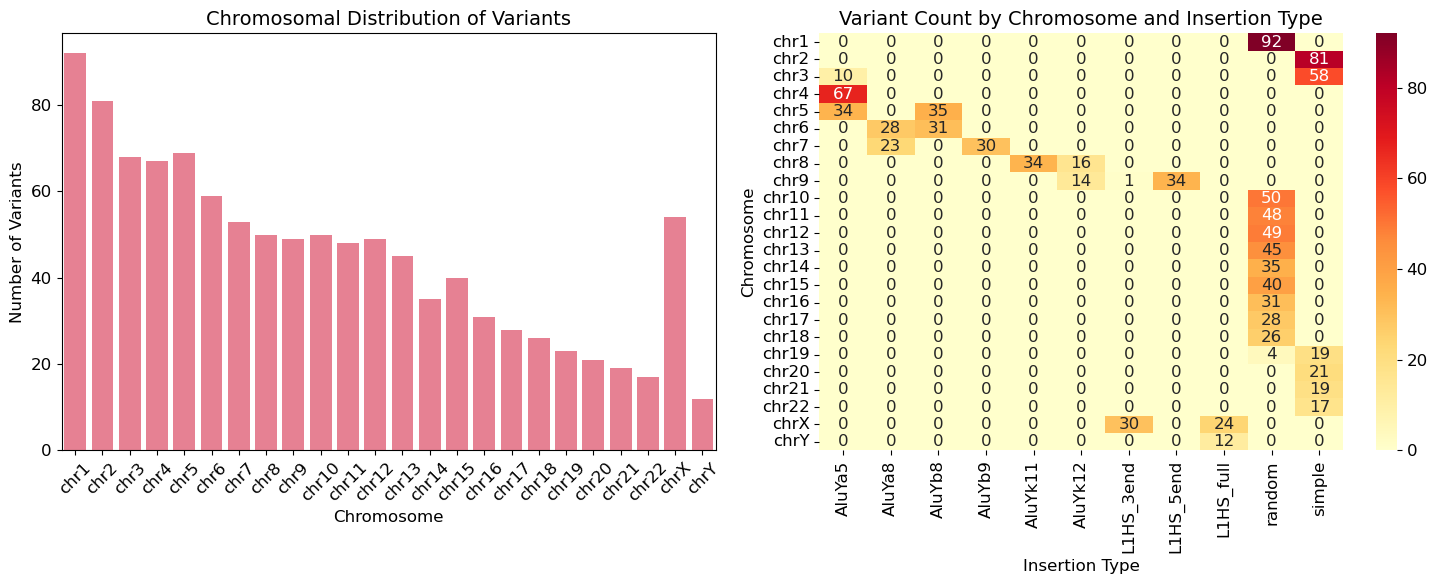

In [82]:
# Analyze chromosomal distribution of variants
if 'chrom' in df.columns and 'insertion_type' in df.columns:
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # First subplot - chromosome distribution
    chrom_dist = df.groupby('chrom').size().reset_index(name='count')
    chrom_order = [f"chr{n}" for n in range(1, 23)] + ['chrX', 'chrY']
    
    sns.barplot(data=chrom_dist, x='chrom', y='count', order=chrom_order, ax=ax1)
    ax1.set_title('Chromosomal Distribution of Variants')
    ax1.set_xlabel('Chromosome')
    ax1.set_ylabel('Number of Variants')
    ax1.tick_params(axis='x', rotation=45)
    
    # Second subplot - heatmap
    pivot_data = df.groupby(['chrom', 'insertion_type']).size().unstack(fill_value=0)
    pivot_data = pivot_data.reindex(chrom_order)
    
    sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='d', ax=ax2)
    ax2.set_title('Variant Count by Chromosome and Insertion Type')
    ax2.set_xlabel('Insertion Type')
    ax2.set_ylabel('Chromosome')
    
    plt.tight_layout()
else:
    missing = []
    if 'chrom' not in df.columns:
        missing.append('chrom')
    if 'insertion_type' not in df.columns:
        missing.append('insertion_type')
    print(f"Warning: Required column(s) not found in data: {', '.join(missing)}")


## Performance Analysis

### True Positive Analysis

Analyzing the detection performance for simulated insertions. True positives are defined as single nova-only variant calls - the ideal outcome for de novo simulation.

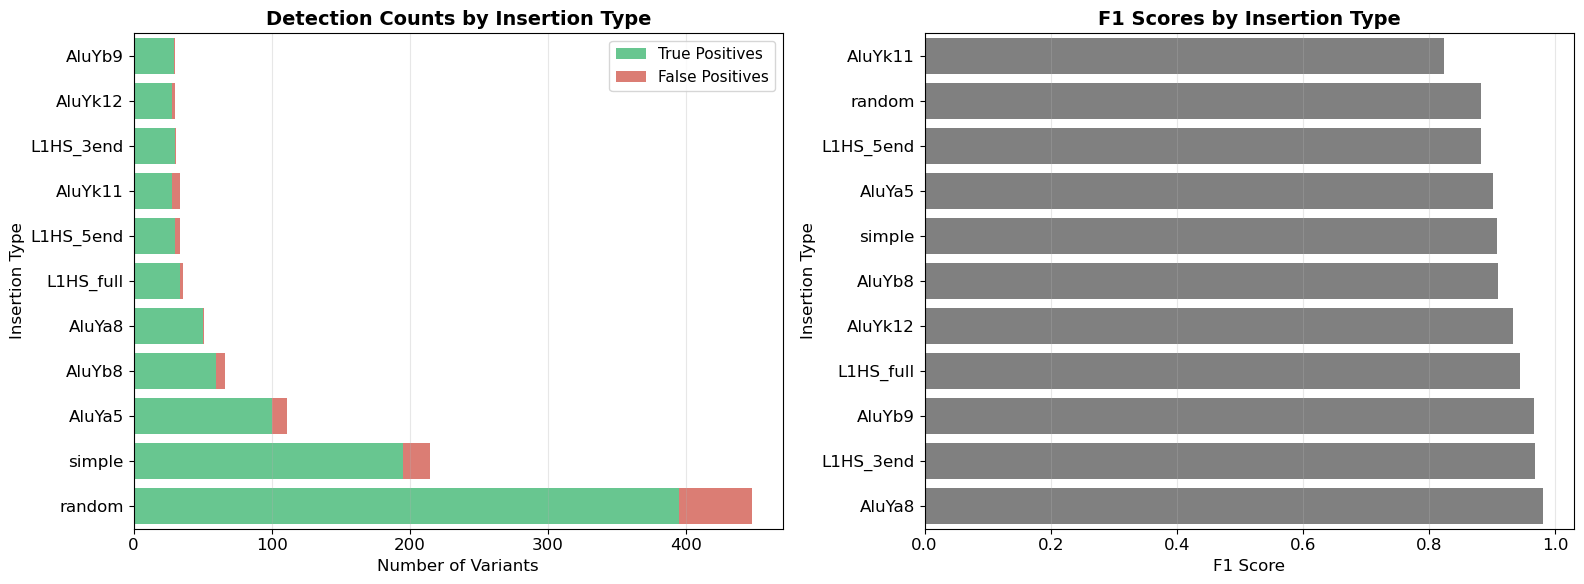


ANALYSIS SUMMARY
Overall true positive rate: 90.1%
By F1 score:
	Best performing type: AluYa8 (F1=0.980)
	Worst performing type: AluYk11 (F1=0.824)


In [69]:
if 'insertion_type' in df.columns and df['insertion_type'].notna().any():
    # Calculate metrics by insertion type
    tp_by_type = []
    insertion_types = df['insertion_type'].dropna().unique()
    
    for ins_type in sorted(insertion_types):
        type_df = df[df['insertion_type'] == ins_type]
        total_detected = len(type_df)
        true_positives = len(type_df[type_df['is_single_nova_only'] == True])
        
        # Calculate rates
        tp_rate = (true_positives / total_detected * 100) if total_detected > 0 else 0
        
        tp_by_type.append({
            'insertion_type': ins_type,
            'total_detected': total_detected,
            'true_positives': true_positives,
            'tp_rate': tp_rate
        })
    
    tp_df = pd.DataFrame(tp_by_type)
    tp_df['precision'] = tp_df['true_positives'] / tp_df['total_detected']
    tp_df['recall'] = tp_df['tp_rate'] / 100  # Convert percentage to decimal
    tp_df['f1_score'] = 2 * (tp_df['precision'] * tp_df['recall']) / (tp_df['precision'] + tp_df['recall'])
    tp_df_sorted = tp_df.sort_values('total_detected', ascending=True)
    
    # Create 2x2 subplot figure
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Detection counts/positives by type
    if len(tp_df) > 0:
        tp_df_sorted = tp_df.sort_values('total_detected', ascending=True)
        sns.barplot(data=tp_df_sorted, y='insertion_type', x='true_positives',
                   color=COLORS['success'], alpha=0.8, ax=ax1, label='True Positives')
        sns.barplot(data=tp_df_sorted, y='insertion_type', x=tp_df_sorted['total_detected'] - tp_df_sorted['true_positives'],
                   color=COLORS['danger'], alpha=0.8, ax=ax1, label='False Positives',
                   left=tp_df_sorted['true_positives'])
        
        ax1.set_title('Detection Counts by Insertion Type', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Number of Variants')
        ax1.set_ylabel('Insertion Type')
        ax1.grid(axis='x', alpha=0.3)
        ax1.legend()
        
    # Plot 2: F1 by type
    if len(tp_df) > 0:
        tp_df_sorted = tp_df.sort_values('f1_score', ascending=True)
        sns.barplot(data=tp_df_sorted, y='insertion_type', x='f1_score',
                   color='gray', ax=ax2)
        ax2.set_title('F1 Scores by Insertion Type', fontsize=14, fontweight='bold')
        ax2.set_xlabel('F1 Score')
        ax2.set_ylabel('Insertion Type')
        ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(data_path / f"{OUTPUT_PREFIX}_true_positive_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print brief summary
    print(f"\nANALYSIS SUMMARY")
    print(f"Overall true positive rate: {overall_tp_rate:.1f}%")
    print(f"By F1 score:")
    if len(tp_df) > 0:
        print(f"\tBest performing type: {tp_df.loc[tp_df['f1_score'].idxmax(), 'insertion_type']} (F1={tp_df['f1_score'].max():.3f})")
        print(f"\tWorst performing type: {tp_df.loc[tp_df['f1_score'].idxmin(), 'insertion_type']} (F1={tp_df['f1_score'].min():.3f})")
    
else:
    print("Warning: Insertion type data not available in CSV file")
    print("Cannot generate insertion type analysis")

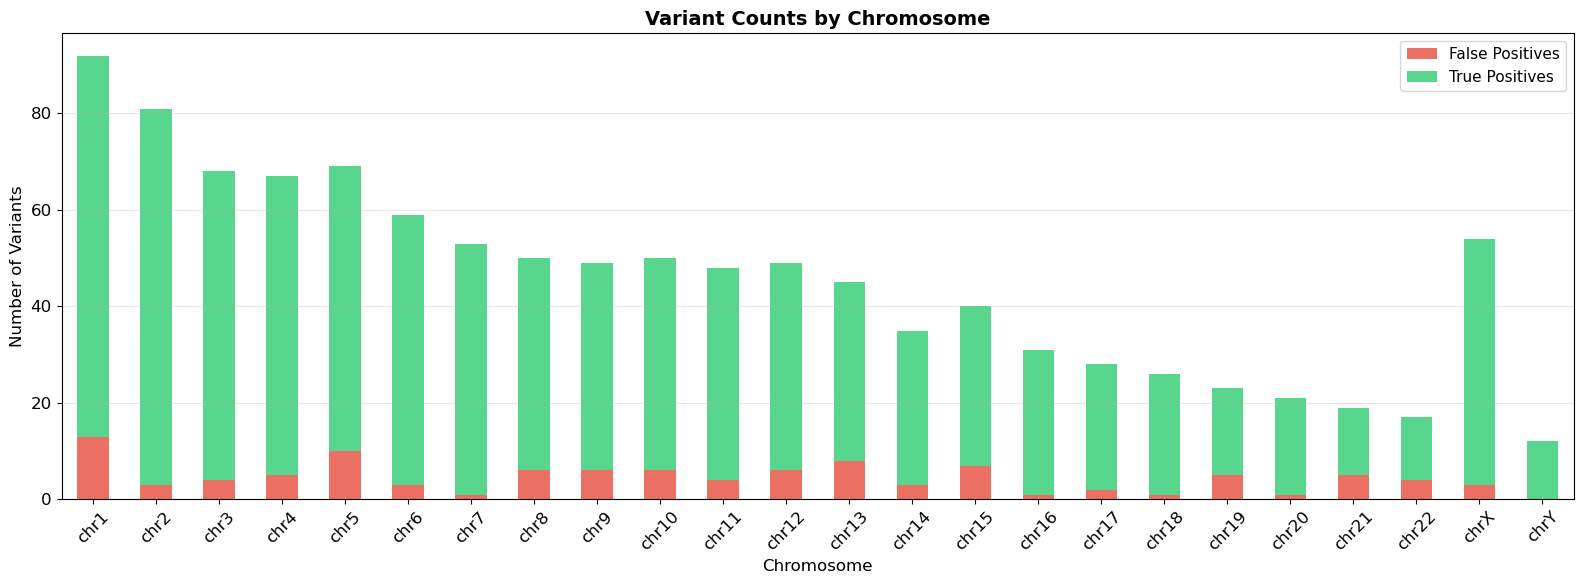

In [85]:
# Analyze true/false positives by chromosome
chrom_analysis = df.groupby(['chrom', 'is_single_nova_only']).size().unstack(fill_value=0)
chrom_analysis.columns = ['False Positives', 'True Positives']

# Sort chromosomes naturally
chrom_order = sorted(chrom_analysis.index, key=lambda x: int(x.replace('chr','')) if x.replace('chr','').isdigit() else float('inf'))
chrom_analysis = chrom_analysis.reindex(chrom_order)

# Create figure
fig, ax = plt.subplots(figsize=(16, 6))

# Create stacked bar plot
chrom_analysis.plot(kind='bar', stacked=True, ax=ax,
                   color=[COLORS['danger'], COLORS['success']], alpha=0.8)

plt.title('Variant Counts by Chromosome', fontsize=14, fontweight='bold')
plt.xlabel('Chromosome')
plt.ylabel('Number of Variants')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='')

plt.tight_layout()
# if SAVE_FIGURES:
    # plt.savefig(data_path / f"{OUTPUT_PREFIX}_chrom_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

### False Positive Analysis

Analyzing variants that are **not** single nova-only calls. These represent false positives in de novo simulation.

False Positive Analysis: 107 unique false positive variants


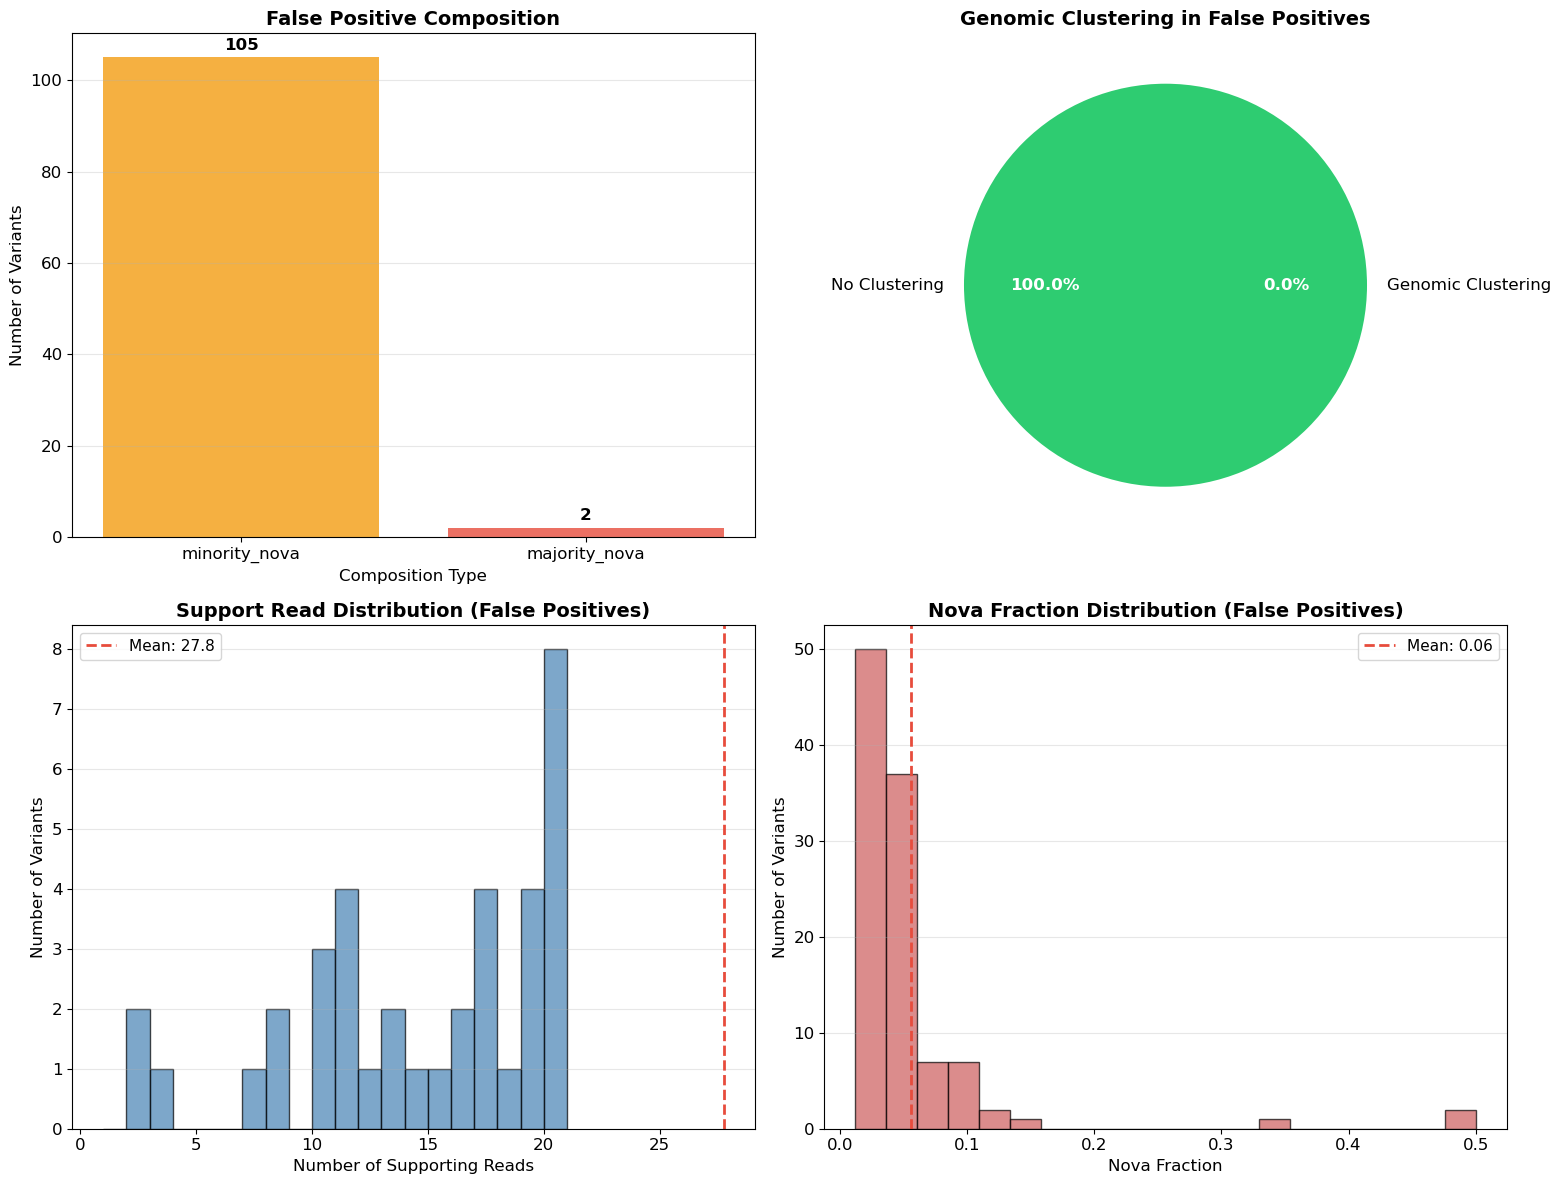


FALSE POSITIVE SUMMARY
Total false positives: 107
Composition breakdown:
  minority_nova: 105 (98.1%)
  majority_nova: 2 (1.9%)
Genomic clustering: 0 (0.0%)


In [27]:
# False Positive Analysis

# Get false positive variants
fp_variants = df[df['is_single_nova_only'] == False]
unique_fp = fp_variants.groupby('variant_index').first().reset_index()

print(f"False Positive Analysis: {len(unique_fp)} unique false positive variants")

if len(unique_fp) > 0:
    # Create false positive analysis visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: False positive composition breakdown
    fp_composition = unique_fp['composition'].value_counts()
    colors = [COLORS['warning'], COLORS['danger']]
    bars1 = ax1.bar(fp_composition.index, fp_composition.values, 
                    color=colors[:len(fp_composition)], alpha=0.8)
    ax1.set_title('False Positive Composition', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Number of Variants')
    ax1.set_xlabel('Composition Type')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Genomic clustering analysis (if available)
    if 'has_genomic_clustering' in unique_fp.columns:
        clustering_counts = unique_fp['has_genomic_clustering'].value_counts()
        labels = ['No Clustering', 'Genomic Clustering']
        sizes = [clustering_counts.get(False, 0), clustering_counts.get(True, 0)]
        colors_clustering = [COLORS['success'], COLORS['danger']]
        
        wedges, texts, autotexts = ax2.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                          colors=colors_clustering)
        ax2.set_title('Genomic Clustering in False Positives', fontsize=14, fontweight='bold')
        
        # Make percentage text bold
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
    else:
        ax2.text(0.5, 0.5, 'Genomic clustering\ndata not available', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title('Genomic Clustering Analysis', fontsize=14, fontweight='bold')
    
    # Plot 3: Support read distribution for false positives
    if 'support_reads' in unique_fp.columns:
        # Limit to reasonable range for visualization
        support_reads = unique_fp['support_reads'].values
        support_reads = support_reads[support_reads <= 20]  # Cap at 20 for better visualization
        
        ax3.hist(support_reads, bins=range(1, max(support_reads)+2), 
                color=COLORS['secondary'], alpha=0.7, edgecolor='black')
        ax3.set_title('Support Read Distribution (False Positives)', fontsize=14, fontweight='bold')
        ax3.set_xlabel('Number of Supporting Reads')
        ax3.set_ylabel('Number of Variants')
        ax3.grid(axis='y', alpha=0.3)
        
        # Add mean line
        mean_support = np.mean(unique_fp['support_reads'])
        ax3.axvline(mean_support, color=COLORS['danger'], linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_support:.1f}')
        ax3.legend()
    
    # Plot 4: Nova fraction distribution for false positives
    if 'nova_fraction' in unique_fp.columns:
        ax4.hist(unique_fp['nova_fraction'], bins=20, color=COLORS['accent'], alpha=0.7, edgecolor='black')
        ax4.set_title('Nova Fraction Distribution (False Positives)', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Nova Fraction')
        ax4.set_ylabel('Number of Variants')
        ax4.grid(axis='y', alpha=0.3)
        
        # Add mean line
        mean_nova_fraction = np.mean(unique_fp['nova_fraction'])
        ax4.axvline(mean_nova_fraction, color=COLORS['danger'], linestyle='--', linewidth=2,
                   label=f'Mean: {mean_nova_fraction:.2f}')
        ax4.legend()
    
    plt.tight_layout()
    if SAVE_FIGURES:
        plt.savefig(data_path / f"{OUTPUT_PREFIX}_false_positive_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print brief summary
    print(f"\nFALSE POSITIVE SUMMARY")
    print(f"Total false positives: {len(unique_fp):,}")
    print(f"Composition breakdown:")
    for comp_type, count in fp_composition.items():
        percentage = (count / len(unique_fp) * 100)
        print(f"  {comp_type}: {count:,} ({percentage:.1f}%)")
    
    if 'has_genomic_clustering' in unique_fp.columns:
        clustering_count = len(unique_fp[unique_fp['has_genomic_clustering'] == True])
        clustering_pct = (clustering_count / len(unique_fp) * 100)
        print(f"Genomic clustering: {clustering_count:,} ({clustering_pct:.1f}%)")
        
else:
    print("No false positive variants detected!")
    
    # Create a simple message plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.text(0.5, 0.5, 'No False Positives Detected!\n\nExcellent simulation quality', 
            ha='center', va='center', transform=ax.transAxes, 
            fontsize=20, fontweight='bold', color=COLORS['success'])
    ax.set_title('False Positive Analysis', fontsize=16, fontweight='bold')
    ax.axis('off')
    
    if SAVE_FIGURES:
        plt.savefig(data_path / f"{OUTPUT_PREFIX}_false_positive_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()

## Detailed Analysis

### Read Composition and Size Accuracy

Detailed analysis of read support patterns and insertion size accuracy.

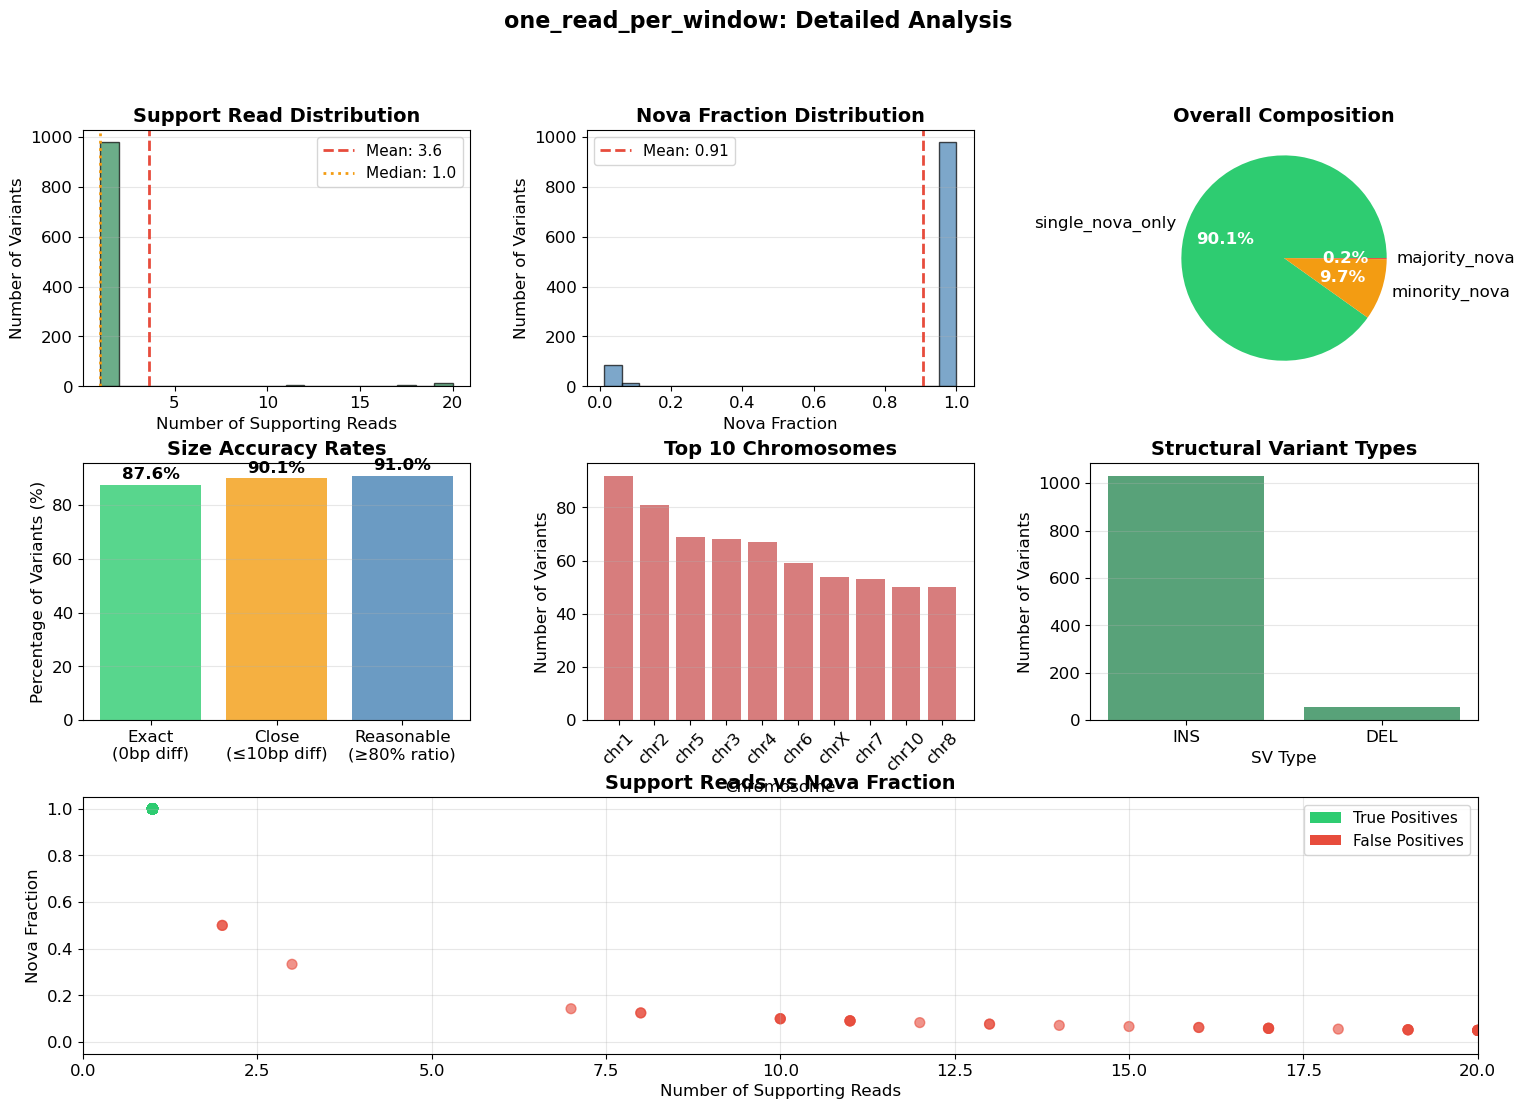


DETAILED ANALYSIS SUMMARY
Total unique variants: 1,086
Mean support reads: 3.6
Mean nova fraction: 0.907
Single-read variants: 979
Perfect nova fraction (1.0): 979


In [70]:
# Detailed Analysis with comprehensive visualizations

# Get unique variants for this analysis
unique_analysis_df = df.groupby('variant_index').agg({
    'support_reads': 'first',
    'nova_reads': 'first',
    'nova_fraction': 'first',
    'composition': 'first',
    'is_single_nova_only': 'first',
    'exact_size_match': 'first' if 'exact_size_match' in df.columns else lambda x: None,
    'close_size_match': 'first' if 'close_size_match' in df.columns else lambda x: None,
    'reasonable_size_match': 'first' if 'reasonable_size_match' in df.columns else lambda x: None,
    'chrom': 'first',
    'svtype': 'first'
}).reset_index()

# Create comprehensive analysis visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Support read distribution
ax1 = fig.add_subplot(gs[0, 0])
support_reads = unique_analysis_df['support_reads'].values
support_reads_capped = support_reads[support_reads <= 20]  # Cap for better visualization
ax1.hist(support_reads_capped, bins=range(1, 21), color=COLORS['primary'], alpha=0.7, edgecolor='black')
ax1.set_title('Support Read Distribution', fontweight='bold')
ax1.set_xlabel('Number of Supporting Reads')
ax1.set_ylabel('Number of Variants')
ax1.grid(axis='y', alpha=0.3)

# Add statistics
mean_support = np.mean(support_reads)
median_support = np.median(support_reads)
ax1.axvline(mean_support, color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: {mean_support:.1f}')
ax1.axvline(median_support, color=COLORS['warning'], linestyle=':', linewidth=2, label=f'Median: {median_support:.1f}')
ax1.legend()

# Plot 2: Nova fraction distribution
ax2 = fig.add_subplot(gs[0, 1])
nova_fractions = unique_analysis_df['nova_fraction'].values
ax2.hist(nova_fractions, bins=20, color=COLORS['secondary'], alpha=0.7, edgecolor='black')
ax2.set_title('Nova Fraction Distribution', fontweight='bold')
ax2.set_xlabel('Nova Fraction')
ax2.set_ylabel('Number of Variants')
ax2.grid(axis='y', alpha=0.3)

# Add statistics
mean_nova_frac = np.mean(nova_fractions)
ax2.axvline(mean_nova_frac, color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: {mean_nova_frac:.2f}')
ax2.legend()

# Plot 3: Composition breakdown
ax3 = fig.add_subplot(gs[0, 2])
composition_counts = unique_analysis_df['composition'].value_counts()
colors_comp = [COLORS['success'], COLORS['warning'], COLORS['danger']]
wedges, texts, autotexts = ax3.pie(composition_counts.values, labels=composition_counts.index, 
                                  autopct='%1.1f%%', colors=colors_comp[:len(composition_counts)])
ax3.set_title('Overall Composition', fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Plot 4: Size accuracy analysis (if available)
if 'exact_size_match' in unique_analysis_df.columns and unique_analysis_df['exact_size_match'].notna().any():
    ax4 = fig.add_subplot(gs[1, 0])
    
    exact_count = len(unique_analysis_df[unique_analysis_df['exact_size_match'] == True])
    close_count = len(unique_analysis_df[unique_analysis_df['close_size_match'] == True])
    reasonable_count = len(unique_analysis_df[unique_analysis_df['reasonable_size_match'] == True])
    total_with_size = len(unique_analysis_df[unique_analysis_df['exact_size_match'].notna()])
    
    if total_with_size > 0:
        categories = ['Exact\n(0bp diff)', 'Close\n(≤10bp diff)', 'Reasonable\n(≥80% ratio)']
        counts = [exact_count, close_count, reasonable_count]
        percentages = [(count / total_with_size * 100) for count in counts]
        
        bars4 = ax4.bar(categories, percentages, color=[COLORS['success'], COLORS['warning'], COLORS['secondary']], alpha=0.8)
        ax4.set_title('Size Accuracy Rates', fontweight='bold')
        ax4.set_ylabel('Percentage of Variants (%)')
        ax4.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for bar, pct in zip(bars4, percentages):
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
                     f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
else:
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.text(0.5, 0.5, 'Size accuracy\ndata not available', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Size Accuracy Analysis', fontweight='bold')

# Plot 5: Chromosomal distribution
ax5 = fig.add_subplot(gs[1, 1])
chrom_counts = unique_analysis_df['chrom'].value_counts().head(10)  # Top 10 chromosomes
bars5 = ax5.bar(range(len(chrom_counts)), chrom_counts.values, color=COLORS['accent'], alpha=0.8)
ax5.set_title('Top 10 Chromosomes', fontweight='bold')
ax5.set_ylabel('Number of Variants')
ax5.set_xlabel('Chromosome')
ax5.set_xticks(range(len(chrom_counts)))
ax5.set_xticklabels(chrom_counts.index, rotation=45)
ax5.grid(axis='y', alpha=0.3)

# Plot 6: SV type distribution
ax6 = fig.add_subplot(gs[1, 2])
svtype_counts = unique_analysis_df['svtype'].value_counts()
bars6 = ax6.bar(svtype_counts.index, svtype_counts.values, color=COLORS['primary'], alpha=0.8)
ax6.set_title('Structural Variant Types', fontweight='bold')
ax6.set_ylabel('Number of Variants')
ax6.set_xlabel('SV Type')
ax6.grid(axis='y', alpha=0.3)

# Plot 7: Support reads vs Nova fraction scatter
ax7 = fig.add_subplot(gs[2, :])
scatter = ax7.scatter(unique_analysis_df['support_reads'], unique_analysis_df['nova_fraction'], 
                     c=unique_analysis_df['is_single_nova_only'].map({True: COLORS['success'], False: COLORS['danger']}),
                     alpha=0.6, s=50)
ax7.set_title('Support Reads vs Nova Fraction', fontweight='bold')
ax7.set_xlabel('Number of Supporting Reads')
ax7.set_ylabel('Nova Fraction')
ax7.grid(True, alpha=0.3)
ax7.set_xlim(0, min(20, unique_analysis_df['support_reads'].max() + 1))
ax7.set_ylim(-0.05, 1.05)

# Add legend for scatter plot
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=COLORS['success'], label='True Positives'),
                  Patch(facecolor=COLORS['danger'], label='False Positives')]
ax7.legend(handles=legend_elements)

plt.suptitle(f'{EXPERIMENT_NAME}: Detailed Analysis', fontsize=16, fontweight='bold')

if SAVE_FIGURES:
    plt.savefig(data_path / f"{OUTPUT_PREFIX}_detailed_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics
print(f"\nDETAILED ANALYSIS SUMMARY")
print(f"Total unique variants: {len(unique_analysis_df):,}")
print(f"Mean support reads: {mean_support:.1f}")
print(f"Mean nova fraction: {mean_nova_frac:.3f}")
print(f"Single-read variants: {len(unique_analysis_df[unique_analysis_df['support_reads'] == 1]):,}")
print(f"Perfect nova fraction (1.0): {len(unique_analysis_df[unique_analysis_df['nova_fraction'] == 1.0]):,}")